# 4章 顧客の行動を予測する

In [ ]:
!pip install japanize-matplotlib
!pip install numexpr

In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime

work_dir = 'WORKING_DIRECTORY'


## 031. データの読み込み

In [ ]:
customer = pd.read_csv(f'{work_dir}/customer_join.csv')
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


In [ ]:
uselog = pd.read_csv(f'{work_dir}/use_log.csv')
uselog.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


## 032. クラスタリングで顧客をグルーピング化

In [ ]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=144)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique())
customer_clustering.head()

[0 3 2 1]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,0
1,5.083333,5.0,7,3,47,0
2,4.583333,5.0,6,3,47,0
3,4.833333,4.5,7,2,47,0
4,3.916667,4.0,6,1,47,0


## 033. クラスタリング結果を分析

In [ ]:
customer_clustering.columns = ['月内平均値', '月内中央値', '月内最大値', '月内最小値', '会員期間', 'cluster']
customer_clustering.groupby('cluster').count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,1249,1249,1249,1249,1249
1,846,846,846,846,846
2,1334,1334,1334,1334,1334
3,763,763,763,763,763


In [ ]:
customer_clustering.groupby('cluster').mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,4.677494,4.671337,7.232986,2.153723,36.915933
1,8.054608,8.039598,10.009456,6.160757,7.072104
2,5.524239,5.375187,8.745877,2.687406,14.843328
3,3.054713,2.888598,4.756225,1.653997,9.263434


## 034. クラスタリング結果を可視化

In [ ]:
from sklearn.decomposition import PCA

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

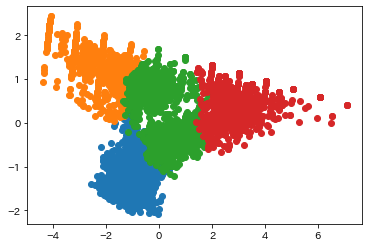

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in customer_clustering['cluster'].unique():
  tmp = pca_df.loc[pca_df['cluster'] == i]
  plt.scatter(tmp[0], tmp[1])

## 035. クラスタリング結果を基に退会顧客の傾向を把握

In [ ]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,1230
1,0,1,19
2,1,0,827
3,1,1,19
4,2,0,785
5,2,1,549
6,3,1,763


In [ ]:
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,2
1,0,1,1247
2,1,0,52
3,1,1,794
4,2,0,228
5,2,1,1106
6,3,0,497
7,3,1,266


## 036. 翌月の利用回数予測を行うための準備

In [ ]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['年月'] = uselog['usedate'].dt.strftime('%Y/%m')
uselog_months = uselog.groupby(['年月', 'customer_id'], as_index=False).count()
uselog_months.rename(columns={'log_id': 'count'}, inplace=True)
del uselog_months['usedate']
uselog_months.head()

,年月,customer_id,count
0,2018/04,AS002855,4
1,2018/04,AS009013,2
2,2018/04,AS009373,3
3,2018/04,AS015315,6
4,2018/04,AS015739,7


In [ ]:
year_months = list(uselog_months['年月'].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months['年月']==year_months[i]]
    tmp.rename(columns={'count': 'count_pred'}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months['年月']==year_months[i-j]]
        del tmp_before['年月']
        tmp_before.rename(columns={'count': f'count_{j-1}'}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,2018/10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,2018/10,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,2018/10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,2018/10,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,2018/10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [ ]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,2018/10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,2018/10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,2018/10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,2018/10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,2018/10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


## 037. 特徴となる変数を付与

In [ ]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on='customer_id', how='left')
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,2018/10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,2018/10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,2018/10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,2018/10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,2018/10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [ ]:
predict_data['now_date'] = pd.to_datetime(predict_data['年月'], format='%Y/%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])
from dateutil.relativedelta import relativedelta
predict_data['period'] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
    predict_data['period'][i] = delta.years*12 + delta.months
predict_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,2018/10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,2018/10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,2018/10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,2018/10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,2018/10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


## 038. 翌月の利用回数予測モデルを作成

In [ ]:
from sklearn import linear_model
import sklearn.model_selection

predict_data = predict_data.query(' "20180401" <= start_date ')

model = linear_model.LinearRegression()
X = predict_data[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period']]
y = predict_data['count_pred']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6192086538476232
0.5724405466639854


## 039. モデルに寄与している変数の確認

In [ ]:
coef = pd.DataFrame({'feature_names': X.columns, 'coefficient': model.coef_})
coef

,feature_names,coefficient
0,count_0,0.343208
1,count_1,0.188683
2,count_2,0.150313
3,count_3,0.202427
4,count_4,0.084496
5,count_5,0.058641
6,period,0.053079


## 040. 翌月の利用回数を予測

In [ ]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [ ]:
model.predict(x_pred)

array([3.84522487, 1.97043063])

In [ ]:
### csvへ出力する
#uselog_months.to_csv(f'{work_dir}/use_log_months.csv', index=False)